In [1]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
import os
model = ChatGoogleGenerativeAI(
                model='gemini-2.0-flash',
                google_api_key=os.getenv('GOOGLE_API_KEY'),
                temperature=0,
                max_output_tokens=1000
            )

model.invoke('Hello')

AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--6fe1c337-674a-4aa8-bc01-ee599e673153-0', usage_metadata={'input_tokens': 1, 'output_tokens': 10, 'total_tokens': 11, 'input_token_details': {'cache_read': 0}})

In [11]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(
    model = 'models/text-embedding-004',
   google_api_key =os.getenv('GOOGLE_API_KEY')
)

embeddings


text="Hello, I am learning about embeddings!"
em = embeddings.embed_query(text)

In [17]:
import os
os.environ["TAVILY_API_KEY"]='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'
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool=TavilySearch(max_results=5)

In [16]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langchain_community.tools  import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [24]:
### generic function to create a retrieval tool
from langchain.tools import tool
from langchain_core.tools import Tool

def make_retriever_tool_from_text(file,name,desc):
    docs=TextLoader(file,encoding="utf-8").load()
    chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
    vs = FAISS.from_documents(chunks, embeddings)
    retriever = vs.as_retriever()

    def tool_func(query:str)->str:
        print(f"📚 Using tool: {name}")
        results = retriever.invoke(query)
        return "\n\n".join(doc.page_content for doc in results)
    
    return Tool(name=name,description=desc,func=tool_func)


internal_tool_1=make_retriever_tool_from_text("doc_1.txt",
                                              "InternalResearchNotes",
                                              "Search internal research notes for experimental results")

internal_tool_1

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x000001FAFD6A09A0>)

In [25]:
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command

def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [26]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

C:\Users\Debdutta Chatterjee\AppData\Local\Temp\ipykernel_2780\3866327344.py:1: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  research_agent=create_react_agent(


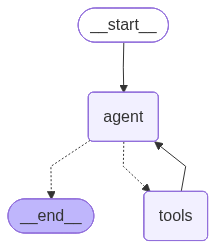

In [28]:
research_agent=create_react_agent(
    model,
    tools=[internal_tool_1,tavily_tool],
    prompt=make_system_prompt("You can only do research. Use the tool that you are binded with, you can use both of them" \
    " You are working with a content writer colleague.")
)

research_agent

In [29]:
from typing import Literal
def research_node(state:MessagesState)-> Command[Literal["blog_generator",END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "blog_generator")

    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

C:\Users\Debdutta Chatterjee\AppData\Local\Temp\ipykernel_2780\553825855.py:1: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  blog_agent=create_react_agent(


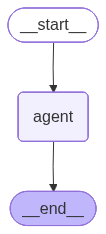

In [31]:
blog_agent=create_react_agent(
    model,
    tools=[],
    prompt=make_system_prompt(
        "You can only write a detailed blog. You are working with a researcher colleague."
    )
)

blog_agent

In [32]:
def blog_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = blog_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="blog_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

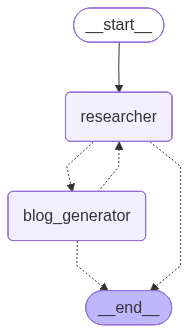

In [33]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("blog_generator", blog_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()
graph

In [34]:
response=graph.invoke({"messages":"Write a detailed blog on transformer variants in production deployments"})
response["messages"][-1].content

'**FINAL ANSWER**\n\n## Transformer Variants in Production: A Practical Guide\n\n**Introduction**\n\nTransformer models have revolutionized natural language processing (NLP), powering a wide range of applications from chatbots and search engines to machine translation and code generation. Their ability to understand and generate human language at scale has led to significant advancements in AI. However, deploying these powerful models in production environments presents unique challenges. Large Transformer models often suffer from high latency, a significant memory footprint, and substantial computational costs, making them difficult to scale and deploy efficiently. To address these challenges, various optimization techniques and Transformer model variants have emerged, each offering different trade-offs between accuracy, speed, and resource consumption. This blog post provides a practical guide to deploying Transformer variants in production, covering key considerations, optimization 

In [35]:
internal_tool_1

from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)
web_search

TavilySearch(max_results=3, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'), api_base_url=None))

C:\Users\Debdutta Chatterjee\AppData\Local\Temp\ipykernel_2780\2505391997.py:3: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  research_agent=create_react_agent(


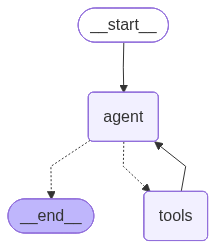

In [37]:
from langgraph.prebuilt import create_react_agent

research_agent=create_react_agent(
    model=model,
    tools=[web_search,internal_tool_1],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="research_agent"
)
research_agent

C:\Users\Debdutta Chatterjee\AppData\Local\Temp\ipykernel_2780\1085878276.py:16: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  math_agent=create_react_agent(


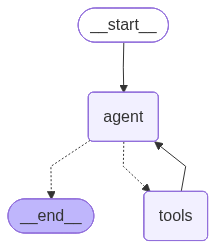

In [39]:
def add(a: float, b: float):
    """Add two numbers."""
    return a + b


def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b


def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b


math_agent=create_react_agent(
    model=model,
    tools=[add,multiply,divide],
    prompt=(
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="math_agent"

)

math_agent

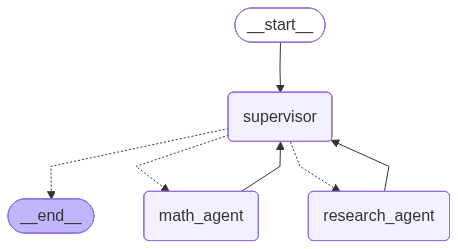

In [43]:
### create supervisor agent

from langgraph_supervisor import create_supervisor
supervisor=create_supervisor(
    model=model,
    agents=[research_agent,math_agent],
    prompt=(
         "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."

    ),
    add_handoff_back_messages=True,
    output_mode="full_history"
).compile()

supervisor

In [44]:
response=supervisor.invoke({"messages":" list all the transformer variants in production deployments from the retriever and then tell me what is 5 plus 10"})

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details..


In [45]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_tavily import TavilySearch
from langchain_core.tools import tool

tavily_tool = TavilySearch(max_results=5)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [46]:
@tool
def scrape_webpages(urls:List[str])->str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

In [49]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"

@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"

@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

In [50]:
# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

In [51]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages


class State(MessagesState):
    next: str

In [52]:
def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

In [56]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent



search_agent = create_react_agent(model, tools=[tavily_tool,internal_tool_1])
search_agent

def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

### sub agent
web_scraper_agent = create_react_agent(model, tools=[scrape_webpages])


def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

C:\Users\Debdutta Chatterjee\AppData\Local\Temp\ipykernel_2780\27177483.py:6: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  search_agent = create_react_agent(model, tools=[tavily_tool,internal_tool_1])
C:\Users\Debdutta Chatterjee\AppData\Local\Temp\ipykernel_2780\27177483.py:22: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  web_scraper_agent = create_react_agent(model, tools=[scrape_webpages])


In [58]:
research_supervisor_node = make_supervisor_node(model, ["search", "web_scraper"])
research_supervisor_node

<function __main__.make_supervisor_node.<locals>.supervisor_node(state: __main__.State) -> langgraph.types.Command[typing.Literal['search', 'web_scraper', '__end__']]>

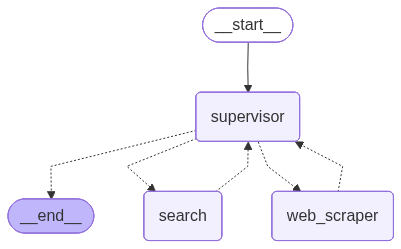

In [59]:
research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()
research_graph

In [60]:
@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    return "\n".join(lines[start:end])

In [63]:
doc_writer_agent = create_react_agent(
    model,
    tools=[write_document, edit_document, read_document],
    prompt=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)


def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

note_taking_agent = create_react_agent(
    model,
    tools=[create_outline, read_document],
    prompt=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)


def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


chart_generating_agent = create_react_agent(
    model, tools=[read_document, python_repl_tool]
)


def chart_generating_node(state: State) -> Command[Literal["supervisor"]]:
    result = chart_generating_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="chart_generator"
                )
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

doc_writing_supervisor_node = make_supervisor_node(
    model, ["doc_writer", "note_taker", "chart_generator"])

C:\Users\Debdutta Chatterjee\AppData\Local\Temp\ipykernel_2780\1406669696.py:1: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  doc_writer_agent = create_react_agent(
C:\Users\Debdutta Chatterjee\AppData\Local\Temp\ipykernel_2780\1406669696.py:23: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  note_taking_agent = create_react_agent(
C:\Users\Debdutta Chatterjee\AppData\Local\Temp\ipykernel_2780\1406669696.py:46: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  chart_generating_agent = create_react

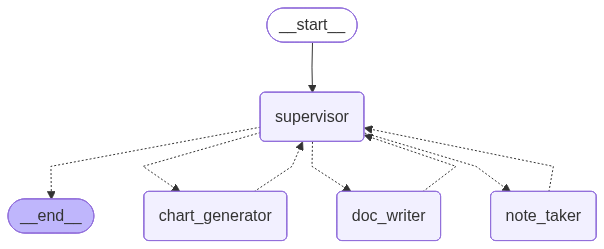

In [64]:
# Create the graph here
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()
paper_writing_graph

In [66]:
from langchain_core.messages import BaseMessage
teams_supervisor_node = make_supervisor_node(model, ["research_team", "writing_team"])
teams_supervisor_node

<function __main__.make_supervisor_node.<locals>.supervisor_node(state: __main__.State) -> langgraph.types.Command[typing.Literal['research_team', 'writing_team', '__end__']]>

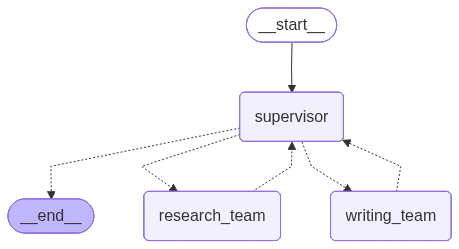

In [67]:
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )


def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="supervisor",
    )


# Define the graph.
super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()
super_graph

In [68]:
response=super_graph.invoke(
    {
        "messages": [
            ("user", "Write about transformer variants in production deployments.")
        ],
    })

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.0-flash
Please retry in 51.340267316s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "gener

KeyboardInterrupt: 